#**NOTEBOOK IMPORTS**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.callbacks import EarlyStopping
import os

# **LOAD DATA**

In [ ]:
path = '/content/drive/MyDrive/Data'
os.listdir(path)

['training', 'validation']

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-07-16 05:35:58--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.159.128, 142.251.120.128, 142.251.161.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.159.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   123MB/s    in 0.7s    

2023-07-16 05:35:59 (123 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (256, 256, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
TRAINING_DIR = '/content/drive/MyDrive/Data/training'
VALIDATION_DIR = '/content/drive/MyDrive/Data/validation'

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed9_1')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 6, 6, 768)


#**DEFINING CALLBACK**

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):

    # Check loss
    if(logs.get('val_accuracy') >= 0.98):

      # Stop if threshold is met
      print("Validation Accuaracy is 90%.....So cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [ ]:
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(4, activation='softmax')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# Set the training parameters
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# **Quantization aware training**

In [ ]:
! pip install -q tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 23.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.1 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.1 which is incompatible.


In [ ]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

In [ ]:
# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)


# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

q_aware_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 quantize_layer (QuantizeLayer)  (None, 256, 256, 3)  3          ['input_1[0][0]']                
                                                                                                  
 quant_conv2d (QuantizeWrapperV  (None, 127, 127, 32  929        ['quantize_layer[0][0]']         
 2)                             )                                                                 
                                                                                              

# **PREPARE THE IMAGE GENERATOR**

In [ ]:
%%time

training_datagen = ImageDataGenerator(
    rescale = 1./255)
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest')

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(256,256),
    class_mode='categorical',
    batch_size=128
)


validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(256,256),
    class_mode='categorical',
    batch_size=30)

Found 4806 images belonging to 4 classes.
Found 1910 images belonging to 4 classes.
CPU times: user 312 ms, sys: 13.8 ms, total: 325 ms
Wall time: 11.7 s


#**Train the model**

In [ ]:
%%time

# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 25,
            epochs = 15,
            validation_steps = 64,
            verbose = 1,
            callbacks=[callbacks])

Epoch 1/15
25/25 [==============================] - 860s 34s/step - loss: 5.4652 - accuracy: 0.5900 - val_loss: 0.5147 - val_accuracy: 0.8304
Epoch 2/15
25/25 [==============================] - 161s 6s/step - loss: 0.4531 - accuracy: 0.8600 - val_loss: 0.3642 - val_accuracy: 0.8639
Epoch 3/15
25/25 [==============================] - 73s 3s/step - loss: 0.2365 - accuracy: 0.9169 - val_loss: 0.3135 - val_accuracy: 0.8848
Epoch 4/15
25/25 [==============================] - 36s 1s/step - loss: 0.1372 - accuracy: 0.9539 - val_loss: 0.2910 - val_accuracy: 0.8937
Epoch 5/15
25/25 [==============================] - 30s 1s/step - loss: 0.1114 - accuracy: 0.9647 - val_loss: 0.2626 - val_accuracy: 0.9005
Epoch 6/15
25/25 [==============================] - 27s 1s/step - loss: 0.0730 - accuracy: 0.9780 - val_loss: 0.2776 - val_accuracy: 0.9073
Epoch 7/15
25/25 [==============================] - 24s 967ms/step - loss: 0.0514 - accuracy: 0.9882 - val_loss: 0.2890 - val_accuracy: 0.9031
Epoch 8/15
25/

# **VISUALIZE THE TRAINING ACCURACY AND LOSS**

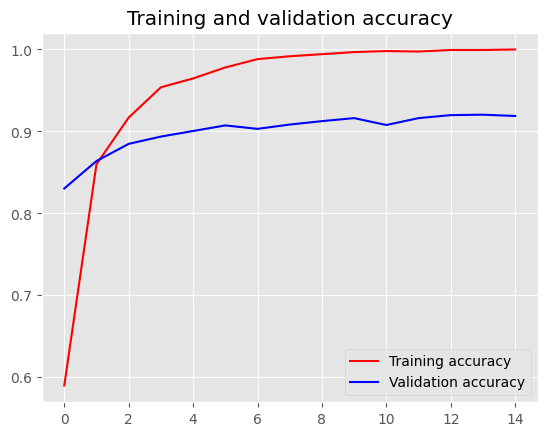

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

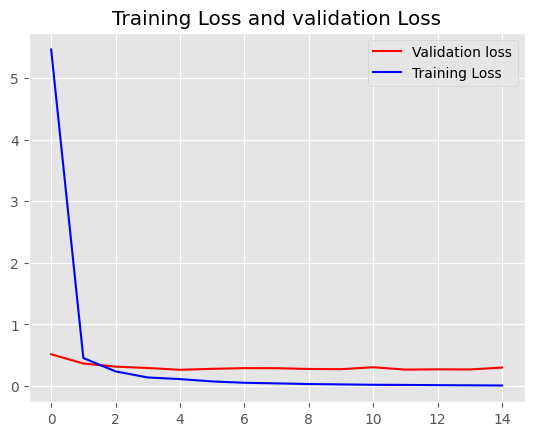

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training Loss and validation Loss')
plt.legend(loc=0)
plt.figure()


plt.show()

# **Apply post-training quantization**

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_model = converter.convert()

In [ ]:
# Convert quantized model to Keras .h5 format
keras_model = tf.keras.models.model_from_json(model.to_json())  # Create Keras model from JSON
keras_model.set_weights(model.get_weights())  # Set weights from quantized model


# **Save Model and Download the model**

In [ ]:
# Save the quantized Keras model to an .h5 file
keras_model.save("quantized_model.h5")

In [ ]:
from google.colab import files
files.download('/content/quantized_model.h5')